In [18]:
from spikeinterface.toolkit.postprocessing import get_template_extremum_channel
import spikeinterface.sortingcomponents as scp

import spikeinterface as si
import spikeinterface.extractors as se 
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw

import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import math

from probeinterface import Probe, get_probe
from probeinterface.plotting import plot_probe

# %matplotlib widget
%matplotlib inline

In [ ]:
#https://gin.g-node.org/NeuralEnsemble/ephy_testing_data
local_path = si.download_dataset(remote_path='mearec/mearec_test_10s.h5')
recording = se.MEArecRecordingExtractor(local_path)
sorting_gt = se.MEArecSortingExtractor(local_path)

In [20]:
channel_ids = recording.get_channel_ids()
fs = recording.get_sampling_frequency()
num_chan = recording.get_num_channels()
num_segments = recording.get_num_segments()

print(f'Channel ids: {channel_ids}')
print(f'Sampling frequency: {fs}')
print(f'Number of channels: {num_chan}')
print(f"Number of segments: {num_segments}")
print(f"Channel inds: {recording.ids_to_indices(channel_ids)}")

Channel ids: ['1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12' '13' '14' '15' '16'
 '17' '18' '19' '20' '21' '22' '23' '24' '25' '26' '27' '28' '29' '30'
 '31' '32']
Sampling frequency: 32000.0
Number of channels: 32
Number of segments: 1
Channel inds: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]


In [21]:
we = si.extract_waveforms(recording, sorting_gt, folder="wf_IC", progress_bar=True,
                          n_jobs=4, total_memory="500M", overwrite=False, load_if_exists=True)

In [22]:
extremum_channels_inds = get_template_extremum_channel(we, peak_sign='both', outputs='index')
print(extremum_channels_inds)

{'#0': 5, '#1': 9, '#2': 19, '#3': 2, '#4': 14, '#5': 12, '#6': 24, '#7': 21, '#8': 22, '#9': 6}


In [23]:
sampling_freq = recording.get_sampling_frequency()
print(sampling_freq)

32000.0


In [24]:
def get_radius_channels(radius_size, channel_ind):
    channel_inds = []
    ch_locations = recording.get_probe().contact_positions
    for ind, ch_location in enumerate(ch_locations):
        if ind == channel_ind: continue
        dist = math.dist(ch_locations[channel_ind], ch_location)
        if dist <= radius_size:
            channel_inds.append(ind)
        # print(f"ch ind: {ind + 1}, dist from peak: {crt_dist}")
    return channel_inds

(<matplotlib.collections.PolyCollection at 0x7fd8581727c0>,
 <matplotlib.collections.PolyCollection at 0x7fd87826d430>)

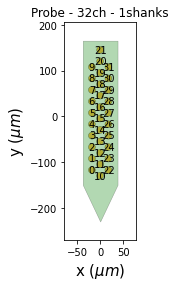

In [25]:
plot_probe(recording.get_probe(), with_channel_index=True)

In [26]:
def radius_search(radius_size, detected_spikes, peak_channel_ind, spike_to_match, time_error_threshold):
    peak_channel_spikes = detected_spikes[detected_spikes['channel_ind'] == peak_channel_ind]
    peak_channel_spikes = np.asarray(sorted(peak_channel_spikes, key=lambda x: x['sample_ind']))
    if len(peak_channel_spikes) == 0: return None, None
    peak_channel_spikes = peak_channel_spikes['sample_ind'] / sampling_freq
    # print(peak_channel_spikes)

    # print(len(peak_channel_spikes))
    for spike_ind, spike_time in enumerate(peak_channel_spikes):
        if (peak_channel_ind, spike_ind) in marked:
            # print("already marked")
            continue
        # print(f"peak channel spike ind: {spike_ind}, spike_time: {spike_time}, spike_to_match: {spike_to_match}")
        if abs(spike_time - spike_to_match) <= time_error_threshold:
            return peak_channel_ind, spike_ind 
    
    channel_inds_in_radius = get_radius_channels(radius_size, channel_ind=peak_channel_ind)
    # print(f"channel inds in radius: {channel_inds_in_radius}")

    for channel_ind in channel_inds_in_radius:
        channel_spikes = detected_spikes[detected_spikes['channel_ind'] == channel_ind]
        channel_spikes = np.asarray(sorted(channel_spikes, key=lambda x: x['sample_ind']))
        if len(channel_spikes) == 0: continue
        channel_spikes = channel_spikes['sample_ind'] / sampling_freq
        for spike_ind, spike_time in enumerate(channel_spikes):
            if (channel_ind, spike_ind) in marked: 
                # print("already marked")
                continue
            if abs(spike_time - spike_to_match) <= time_error_threshold:
                return channel_ind, spike_ind
    
    return None, None

In [27]:
def evaluate_detection(recording, detected_spikes, gt_sorting, time_error_threshold, radius_size):
    matched_gt_spikes = 0
    # time_error_threshold = 0.0001 # 0.1ms
    # radius_size = 0 # um
    total_gt_spikes = 0
    for unit in sorting_gt.get_unit_ids():
        peak_channel_ind = int(extremum_channels_inds[unit])
        gt_spikes = sorting_gt.get_unit_spike_train(unit) / sampling_freq
        total_gt_spikes += len(gt_spikes)
        # print(f"unit: {unit}, num spikes: {len(gt_spikes)}")

        for spike_time in gt_spikes:
            channel_ind, spike_ind = radius_search(radius_size=radius_size, detected_spikes=peaks, peak_channel_ind=peak_channel_ind, spike_to_match=spike_time, time_error_threshold=time_error_threshold)
            # print(f"unit: {unit}, channel_ind: {channel_ind}, spike_ind: {spike_ind}")
            if channel_ind != None and spike_ind != None:
                marked[(channel_ind, spike_ind)] = True
                matched_gt_spikes += 1
    # print(f"matched_gt_spikes: {matched_gt_spikes}, total_gt_spikes: {total_gt_spikes}")
    recall = matched_gt_spikes / (matched_gt_spikes + (total_gt_spikes - matched_gt_spikes))
    precision = matched_gt_spikes / (matched_gt_spikes + (len(detected_spikes) - len(marked)))
    accuracy = matched_gt_spikes / (matched_gt_spikes + (total_gt_spikes - matched_gt_spikes) + (len(detected_spikes) - len(marked)))
    # print(f"recall: {recall}")
    print(f"total_detected_spikes: {len(detected_spikes)}, total_gt_spikes: {total_gt_spikes}, matched_spikes: {matched_gt_spikes}")
    # return matched_gt_spikes, total_gt_spikes, recall
    return accuracy, precision, recall

In [28]:
import sys
import io
import contextlib
@contextlib.contextmanager
def silence():
    sys.stdout, old = io.StringIO(), sys.stdout
    try:
        yield
    finally:
        sys.stdout = old

In [29]:
def plot_metrics(detect_peaks_threshold_list, accuracys, precisions, recalls, x_label="Detection threshold"):
    plt.plot(detect_peaks_threshold_list, accuracys)
    plt.xlabel(x_label)
    plt.ylabel("Accuracy")
    plt.show()

    plt.plot(detect_peaks_threshold_list, precisions)
    plt.xlabel(x_label)
    plt.ylabel("Precision")
    plt.show()

    plt.plot(detect_peaks_threshold_list, recalls)
    plt.xlabel(x_label)
    plt.ylabel("Recall")
    plt.show()
        

## Herding Spikes 2 detection (with locally exclusive spikes)
recall lower than expected? bandpass filter greatly improves it

search radius size: 50
total_detected_spikes: 771, total_gt_spikes: 747, matched_spikes: 720
detection threshold: 15, accuracy: 0.9022556390977443, precision: 0.933852140077821, recall: 0.963855421686747

total_detected_spikes: 751, total_gt_spikes: 747, matched_spikes: 715
detection threshold: 20, accuracy: 0.913154533844189, precision: 0.952063914780293, recall: 0.9571619812583668

total_detected_spikes: 715, total_gt_spikes: 747, matched_spikes: 689
detection threshold: 25, accuracy: 0.8913324708926261, precision: 0.9636363636363636, recall: 0.9223560910307899



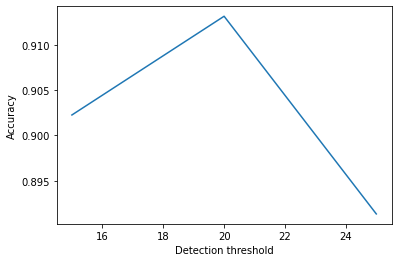

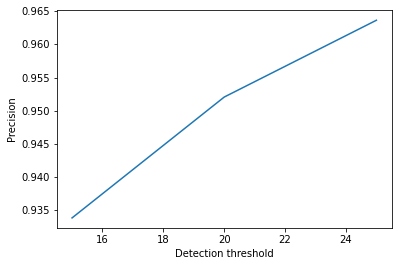

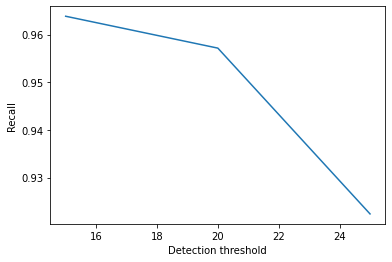

In [40]:
detect_peaks_threshold_list = [15, 20, 25]
radius_size = 50 #um
time_err_threshold = 0.0002 # 0.2 ms
precisions = []
recalls = []
accuracys = []

filtered_recording = st.bandpass_filter(recording, freq_min=300.0, freq_max=6000.0)
print(f"search radius size: {radius_size}")
for threshold in detect_peaks_threshold_list:
    with silence():
        peaks = scp.hs2_spike_detection(recording=filtered_recording, to_localize=False, detect_threshold=threshold)
    marked = {}   
    accuracy, precision, recall = evaluate_detection(recording=recording, detected_spikes=peaks, gt_sorting=sorting_gt, time_error_threshold=time_err_threshold, radius_size=radius_size)
    print(f"detection threshold: {threshold}, accuracy: {accuracy}, precision: {precision}, recall: {recall}\n")
    precisions.append(precision)
    recalls.append(recall)
    accuracys.append(accuracy)

plot_metrics(detect_peaks_threshold_list, accuracys, precisions, recalls)

## detect_peaks (method = by channel)

search radius size: 0, time_err_threshold: 0.2 ms
total_detected_spikes: 851133, total_gt_spikes: 747, matched_spikes: 745
detection threshold: 1, accuracy: 0.0008753018028867336, precision: 0.0008753038596788046, recall: 0.9973226238286479

total_detected_spikes: 24501, total_gt_spikes: 747, matched_spikes: 744
detection threshold: 3, accuracy: 0.030362389813907934, precision: 0.03036610750581609, recall: 0.9959839357429718

total_detected_spikes: 7054, total_gt_spikes: 747, matched_spikes: 744
detection threshold: 5, accuracy: 0.10542723536913702, precision: 0.10547207258293168, recall: 0.9959839357429718

total_detected_spikes: 3453, total_gt_spikes: 747, matched_spikes: 716
detection threshold: 7, accuracy: 0.20551090700344432, precision: 0.20735592238633072, recall: 0.9585006693440429

total_detected_spikes: 1646, total_gt_spikes: 747, matched_spikes: 412
detection threshold: 9, accuracy: 0.20797576981322563, precision: 0.2503037667071689, recall: 0.5515394912985274



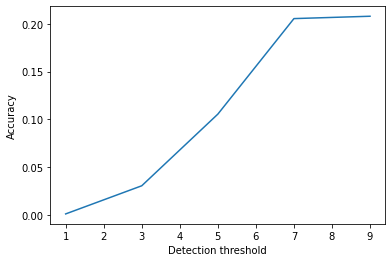

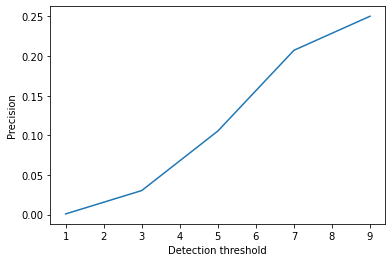

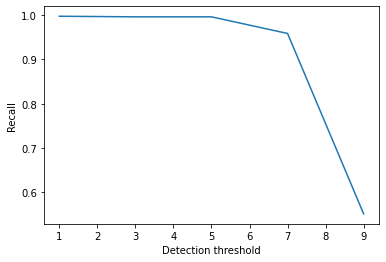

In [31]:
detect_peaks_threshold_list = [1, 3, 5, 7, 9] # In median absolute deviations (MAD).
radius_size = 0 #um
time_err_threshold = 0.0002 # 0.2 ms
precisions = []
recalls = []
accuracys = []

print(f"search radius size: {radius_size}, time_err_threshold: {time_err_threshold * 1000} ms")
for threshold in detect_peaks_threshold_list:
    peaks = scp.detect_peaks(recording=recording, detect_threshold=threshold)
    marked = {}   
    accuracy, precision, recall = evaluate_detection(recording=recording, detected_spikes=peaks, gt_sorting=sorting_gt, time_error_threshold=time_err_threshold, radius_size=radius_size)
    print(f"detection threshold: {threshold}, accuracy: {accuracy}, precision: {precision}, recall: {recall}\n")
    precisions.append(precision)
    recalls.append(recall)
    accuracys.append(accuracy)

plot_metrics(detect_peaks_threshold_list, accuracys, precisions, recalls)

search radius size: 50, time_err_threshold: 0.2 ms
total_detected_spikes: 851133, total_gt_spikes: 747, matched_spikes: 747
detection threshold: 1, accuracy: 0.0008776536686980766, precision: 0.0008776536686980766, recall: 1.0

total_detected_spikes: 24501, total_gt_spikes: 747, matched_spikes: 747
detection threshold: 3, accuracy: 0.03048855148769438, precision: 0.03048855148769438, recall: 1.0

total_detected_spikes: 7054, total_gt_spikes: 747, matched_spikes: 747
detection threshold: 5, accuracy: 0.10589736319818542, precision: 0.10589736319818542, recall: 1.0

total_detected_spikes: 3453, total_gt_spikes: 747, matched_spikes: 728
detection threshold: 7, accuracy: 0.20967741935483872, precision: 0.21083116130900667, recall: 0.9745649263721553

total_detected_spikes: 1646, total_gt_spikes: 747, matched_spikes: 423
detection threshold: 9, accuracy: 0.2147208121827411, precision: 0.25698663426488455, recall: 0.5662650602409639



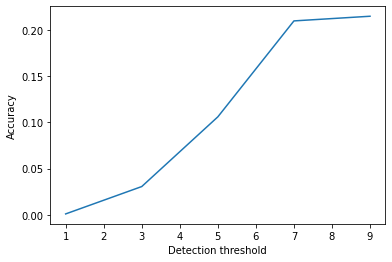

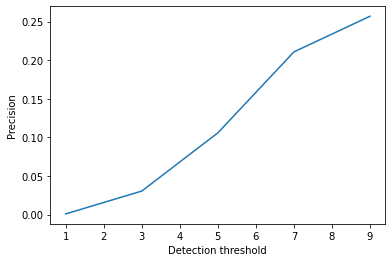

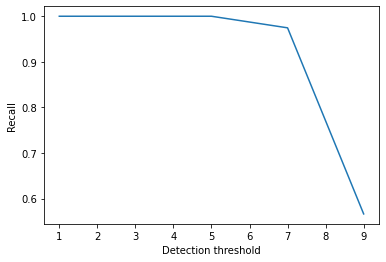

In [32]:
detect_peaks_threshold_list = [1, 3, 5, 7, 9] # In median absolute deviations (MAD).
radius_size = 50 #um
time_err_threshold = 0.0002 # 0.2 ms
precisions = []
recalls = []
accuracys = []

print(f"search radius size: {radius_size}, time_err_threshold: {time_err_threshold * 1000} ms")
for threshold in detect_peaks_threshold_list:
    peaks = scp.detect_peaks(recording=recording, detect_threshold=threshold)
    marked = {}   
    accuracy, precision, recall = evaluate_detection(recording=recording, detected_spikes=peaks, gt_sorting=sorting_gt, time_error_threshold=time_err_threshold, radius_size=radius_size)
    print(f"detection threshold: {threshold}, accuracy: {accuracy}, precision: {precision}, recall: {recall}\n")
    precisions.append(precision)
    recalls.append(recall)
    accuracys.append(accuracy)

plot_metrics(detect_peaks_threshold_list, accuracys, precisions, recalls)

## detect_peaks (method = locally exclusive)

search radius size: 50, time_err_threshold: 0.2 ms
total_detected_spikes: 204279, total_gt_spikes: 747, matched_spikes: 747
detection threshold: 1, accuracy: 0.00365676354397662, precision: 0.00365676354397662, recall: 1.0

total_detected_spikes: 9465, total_gt_spikes: 747, matched_spikes: 747
detection threshold: 3, accuracy: 0.07892234548335975, precision: 0.07892234548335975, recall: 1.0

total_detected_spikes: 1628, total_gt_spikes: 747, matched_spikes: 747
detection threshold: 5, accuracy: 0.45884520884520885, precision: 0.45884520884520885, recall: 1.0

total_detected_spikes: 1050, total_gt_spikes: 747, matched_spikes: 728
detection threshold: 7, accuracy: 0.6810102899906455, precision: 0.6933333333333334, recall: 0.9745649263721553

total_detected_spikes: 446, total_gt_spikes: 747, matched_spikes: 423
detection threshold: 9, accuracy: 0.5493506493506494, precision: 0.9484304932735426, recall: 0.5662650602409639



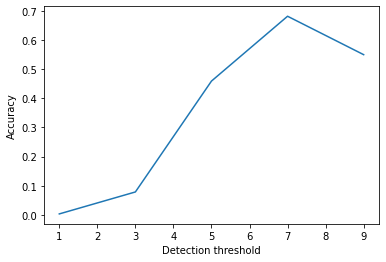

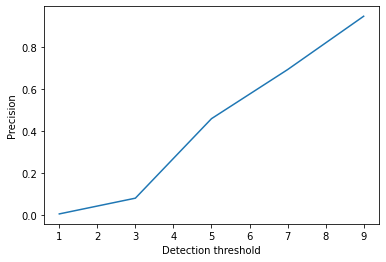

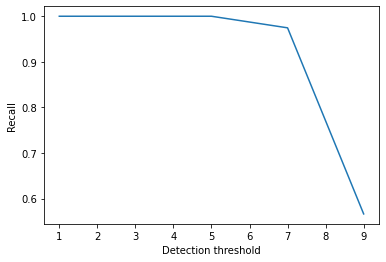

In [33]:
detect_peaks_threshold_list = [1, 3, 5, 7, 9] # In median absolute deviations (MAD).
radius_size = 50 #um
time_err_threshold = 0.0002 # 0.2 ms
precisions = []
recalls = []
accuracys = []

print(f"search radius size: {radius_size}, time_err_threshold: {time_err_threshold * 1000} ms")
for threshold in detect_peaks_threshold_list:
    peaks = scp.detect_peaks(recording=recording, detect_threshold=threshold, method='locally_exclusive')
    marked = {}   
    accuracy, precision, recall = evaluate_detection(recording=recording, detected_spikes=peaks, gt_sorting=sorting_gt, time_error_threshold=time_err_threshold, radius_size=radius_size)
    print(f"detection threshold: {threshold}, accuracy: {accuracy}, precision: {precision}, recall: {recall}\n")
    precisions.append(precision)
    recalls.append(recall)
    accuracys.append(accuracy)

plot_metrics(detect_peaks_threshold_list, accuracys, precisions, recalls)

## detect_peaks evaluation by making spikes locally exclusive

In [34]:
def radius_search_2(radius_size, detected_spikes, peak_channel_ind, spike_to_match, time_error_threshold):
    duplicate_spikes = []
    channel_inds_in_radius = get_radius_channels(radius_size, channel_ind=peak_channel_ind)
    channel_inds_in_radius.append(peak_channel_ind)
    # print(f"channel inds in radius: {channel_inds_in_radius}")

    for channel_ind in channel_inds_in_radius:
        channel_spikes = detected_spikes[detected_spikes['channel_ind'] == channel_ind]
        # channel_spikes = np.asarray(sorted(channel_spikes, key=lambda x: x['sample_ind']))
        if len(channel_spikes) == 0: continue
        channel_spikes = channel_spikes['sample_ind'] / sampling_freq
        for spike_ind, spike_time in enumerate(channel_spikes):
            if (channel_ind, spike_ind) in marked: 
                # print("already marked")
                continue
            if abs(spike_time - spike_to_match) <= time_error_threshold:
                duplicate_spikes.append((channel_ind, spike_ind))
    
    if len(duplicate_spikes) == 0: return [(None, None)]
    else: return duplicate_spikes

In [35]:
def evaluate_detection_2(recording, detected_spikes, gt_sorting, time_error_threshold, radius_size):
    matched_gt_spikes = 0
    total_gt_spikes = 0
    for unit in sorting_gt.get_unit_ids():
        peak_channel_ind = int(extremum_channels_inds[unit])
        gt_spikes = sorting_gt.get_unit_spike_train(unit) / sampling_freq
        total_gt_spikes += len(gt_spikes)

        # print(f"unit: {unit}, num gt spikes: {len(gt_spikes)}")
        for gt_ind, spike_time in enumerate(gt_spikes):
            channel_spike_ind_list = radius_search_2(radius_size=radius_size, detected_spikes=peaks, peak_channel_ind=peak_channel_ind, spike_to_match=spike_time, time_error_threshold=time_error_threshold)
            # print(f"channel_spike_ind_list: {channel_spike_ind_list}")
            # print(f"finished looking for gt spike with ind: {gt_ind}")

            matched_gt_spike = False
            for (channel_ind, spike_ind) in channel_spike_ind_list:
                if channel_ind != None and spike_ind != None:
                    marked[(channel_ind, spike_ind)] = True
                    matched_gt_spike = True
            if matched_gt_spike == True: matched_gt_spikes += 1
    recall = matched_gt_spikes / (matched_gt_spikes + (total_gt_spikes - matched_gt_spikes))
    precision = matched_gt_spikes / (matched_gt_spikes + (len(detected_spikes) - len(marked)))
    accuracy = matched_gt_spikes / (matched_gt_spikes + (total_gt_spikes - matched_gt_spikes) + (len(detected_spikes) - len(marked)))
    print(f"total_detected_spikes: {len(detected_spikes)}, matched_detected_spikes: {len(marked)}, total_gt_spikes: {total_gt_spikes}, matched_gt_spikes: {matched_gt_spikes}")
    return accuracy, precision, recall

search radius size: 50, time_err_threshold: 0.4 ms
total_detected_spikes: 18195, matched_detected_spikes: 7679, total_gt_spikes: 747, matched_gt_spikes: 747
detection threshold: 3, accuracy: 0.06632335967326644, precision: 0.06632335967326644, recall: 1.0

total_detected_spikes: 4918, matched_detected_spikes: 4563, total_gt_spikes: 747, matched_gt_spikes: 746
detection threshold: 5, accuracy: 0.676950998185118, precision: 0.6775658492279746, recall: 0.998661311914324

total_detected_spikes: 2673, matched_detected_spikes: 2648, total_gt_spikes: 747, matched_gt_spikes: 742
detection threshold: 7, accuracy: 0.961139896373057, precision: 0.9674054758800521, recall: 0.9933065595716198

total_detected_spikes: 1521, matched_detected_spikes: 1521, total_gt_spikes: 747, matched_gt_spikes: 526
detection threshold: 9, accuracy: 0.7041499330655957, precision: 1.0, recall: 0.7041499330655957



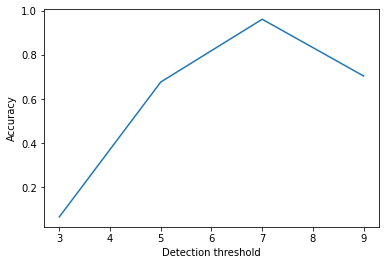

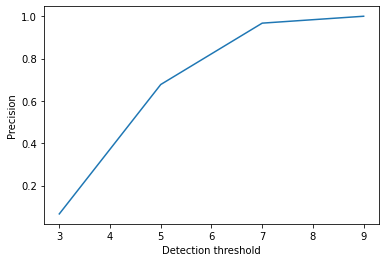

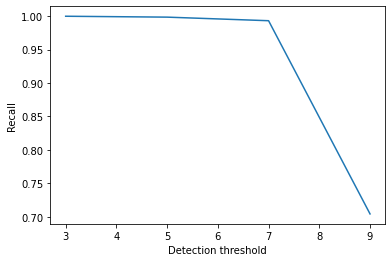

In [44]:
detect_peaks_threshold_list = [3, 5, 7, 9] # In median absolute deviations (MAD).
radius_size = 50 #um
time_err_threshold = 0.0004
precisions = []
recalls = []
accuracys = []

print(f"search radius size: {radius_size}, time_err_threshold: {time_err_threshold * 1000} ms")
for threshold in detect_peaks_threshold_list:
    peaks = scp.detect_peaks(recording=filtered_recording, detect_threshold=threshold)
    marked = {}   
    accuracy, precision, recall = evaluate_detection_2(recording=recording, detected_spikes=peaks, gt_sorting=sorting_gt, time_error_threshold=time_err_threshold, radius_size=radius_size)
    print(f"detection threshold: {threshold}, accuracy: {accuracy}, precision: {precision}, recall: {recall}\n")
    precisions.append(precision)
    recalls.append(recall)
    accuracys.append(accuracy)

plot_metrics(detect_peaks_threshold_list, accuracys, precisions, recalls)

## Visualising accuracy per unit and SNR

In [37]:
def evaluate_detection_per_unit(recording, detected_spikes, gt_sorting, time_error_threshold, radius_size):
    precision_per_unit = []
    recalls_per_unit = []
    accuracy_per_unit = []

    total_peak_channel_detected_spikes = 0
    for unit in sorting_gt.get_unit_ids():
        matched_gt_spikes = 0
        marked = {}
        peak_channel_ind = int(extremum_channels_inds[unit])
        gt_spikes = sorting_gt.get_unit_spike_train(unit) / sampling_freq
        crt_unit_gt_spikes = len(gt_spikes)

        for spike_time in gt_spikes:
            channel_ind, spike_ind = radius_search(radius_size=radius_size, detected_spikes=peaks, peak_channel_ind=peak_channel_ind, spike_to_match=spike_time, time_error_threshold=time_error_threshold)
            if channel_ind != None and spike_ind != None:
                marked[(channel_ind, spike_ind)] = True
                matched_gt_spikes += 1

        peak_channel_spikes = detected_spikes[detected_spikes['channel_ind'] == peak_channel_ind]
        total_peak_channel_detected_spikes += len(peak_channel_spikes)
        print(f"spikes detected on peak channel: {len(peak_channel_spikes)}, matched gt spikes: {matched_gt_spikes}, crt gt unit spikes: {crt_unit_gt_spikes}")
        recall = matched_gt_spikes / (matched_gt_spikes + (crt_unit_gt_spikes - matched_gt_spikes))
        precision = matched_gt_spikes / (matched_gt_spikes + (len(peak_channel_spikes) - len(marked)))
        accuracy = matched_gt_spikes / (matched_gt_spikes + (crt_unit_gt_spikes - matched_gt_spikes) + (len(peak_channel_spikes) - len(marked)))

        precision_per_unit.append(precision)
        recalls_per_unit.append(recall)
        accuracy_per_unit.append(accuracy)

        print(f"unit ind: {unit}, SNR: {SNRs[unit]:.2f}, accuracy: {accuracy:.2f}, precision: {precision:.2f}, recall: {recall:.2f}\n")

    # print(f"total_detected_spikes: {len(detected_spikes)}, total_gt_spikes: {total_gt_spikes}, matched_spikes: {matched_gt_spikes}")
    # return matched_gt_spikes, total_gt_spikes, recall
    print(f"total spikes detected on peak channels associated with gt units: {total_peak_channel_detected_spikes}")
    print(f"total detected spikes amongst all channels: {len(detected_spikes)}")
    print(f"num of unique channels spikes were detected on: {len(np.unique(detected_spikes['channel_ind']))}")
    print(f"num of channels on the recording: {recording.get_num_channels()}")
    return accuracy_per_unit, precision_per_unit, recalls_per_unit

In [38]:
SNRs = st.compute_snrs(waveform_extractor=we)
print(SNRs)

{'#0': 23.44994, '#1': 25.56585, '#2': 11.997738, '#3': 21.852982, '#4': 6.8965316, '#5': 5.176554, '#6': 19.937574, '#7': 7.4566193, '#8': 6.640268, '#9': 7.2473836}


In [39]:
radius_size = 0 #um
time_err_threshold = 0.0001
detect_threshold = 5

print(f"search radius size: {radius_size}, time_err_threshold: {time_err_threshold * 1000} ms")
peaks = scp.detect_peaks(recording=recording, detect_threshold=detect_threshold)
marked = {}   
accuracy_per_unit, precision_per_unit, recalls_per_unit = evaluate_detection_per_unit(recording=recording, detected_spikes=peaks, gt_sorting=sorting_gt, time_error_threshold=time_err_threshold, radius_size=radius_size)
# plot_metrics(list(SNRs.values()), accuracy_per_unit, precision_per_unit, recalls_per_unit, x_label='SNR')

search radius size: 0, time_err_threshold: 0.1 ms
spikes detected on peak channel: 99, matched gt spikes: 53, crt gt unit spikes: 53
unit ind: #0, SNR: 23.45, accuracy: 0.54, precision: 0.54, recall: 1.00

spikes detected on peak channel: 129, matched gt spikes: 50, crt gt unit spikes: 50
unit ind: #1, SNR: 25.57, accuracy: 0.39, precision: 0.39, recall: 1.00

spikes detected on peak channel: 140, matched gt spikes: 42, crt gt unit spikes: 43
unit ind: #2, SNR: 12.00, accuracy: 0.30, precision: 0.30, recall: 0.98

spikes detected on peak channel: 234, matched gt spikes: 30, crt gt unit spikes: 30
unit ind: #3, SNR: 21.85, accuracy: 0.13, precision: 0.13, recall: 1.00

spikes detected on peak channel: 324, matched gt spikes: 47, crt gt unit spikes: 48
unit ind: #4, SNR: 6.90, accuracy: 0.14, precision: 0.15, recall: 0.98

spikes detected on peak channel: 297, matched gt spikes: 20, crt gt unit spikes: 37
unit ind: #5, SNR: 5.18, accuracy: 0.06, precision: 0.07, recall: 0.54

spikes dete